In [1]:
from scipy.spatial import Voronoi, voronoi_plot_2d, Delaunay, delaunay_plot_2d
import numpy as np
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy import ndimage

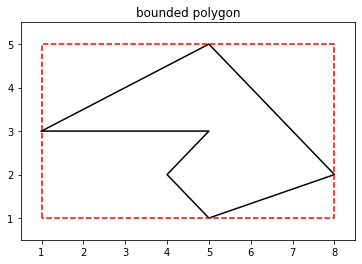

In [180]:
polygon = np.array([[1, 3],
       [5, 5],
       [8, 2],
       [5, 1],
       [4, 2],
       [5, 3],
       [1, 3]])

xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])


plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.title('bounded polygon')
plt.savefig('1', dpi=300)
plt.show()

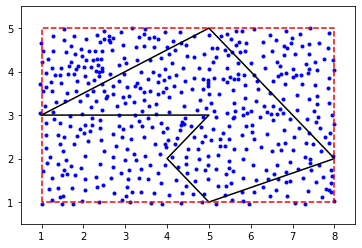

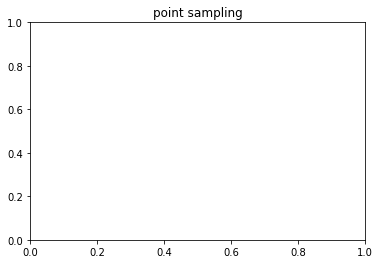

In [182]:
n = 2
r = 0.05
k = 30
rmean = 0.1

xmin,ymin = min(polygon[:,0]),min(polygon[:,1])
xmax,ymax = max(polygon[:,0]),max(polygon[:,1])
width,height = xmax-xmin,ymax-ymin

#step 0
w = r
cols = int(width/w)
rows = int(height/w)

grid = np.array([[None,None,None]]*cols*rows)
active = []

#step 1
pos = np.random.rand(n+1)*[width,height,rmean]#+np.array([xmin,ymin])

i = int(pos[0]/w)
j = int(pos[1]/w)
grid[i+j*cols] = pos
active.append(pos)
# current = active

r_new =  np.random.normal(rmean,0.05)

#step 2
while len(active) > 0:
# for step in range(40):
    randID = random.randint(0,len(active)-1)
    pos = active[randID]
    found = False
    for i in range(k):
        valid_sample = True
        a = random.random()*2*np.pi
        # dist = random.random()**(pos[2]+r_new)+(pos[2]+r_new)
        dist = pos[2]+r_new
        sample = pos +[np.cos(a)*dist,np.sin(a)*dist,r_new-pos[2]]#+np.array([xmin,ymin])
        col, row = int(sample[0]/w), int(sample[1]/w)
        if(col>-1 and row>-1 and col<cols and row<rows and not grid[col+row*cols][0]):
            for i in range(-5,6):
                for j in range(-5,6):
                    if((col+i)>-1 and (col+i)<cols and (row+j)>-1 and (row+j)<rows):
                        neighbour = grid[(col+i)+(row+j)*cols]    
                        if(neighbour[0] and ((sample[0]-neighbour[0])**2+(sample[1]-neighbour[1])**2)**0.5 < neighbour[2]+r_new):
                            valid_sample = False
            if(valid_sample == True):
                found = True
                grid[col+row*cols] = sample #+np.array([xmin,ymin])
                active.append(sample)
                r_new =  np.random.normal(rmean,0.05)
                # if(r_new < rmean/2): active = current
                # curent = active
                break
    if(not found):
        active.pop(randID)

points = np.array([i+[xmin,ymin,0] for i in grid if i[0]])

fig, ax = plt.subplots()
for i in points:
    plt.plot(i[0],i[1],'b.')
    # particle = plt.Circle((i[0],i[1]), i[2], fill=False)
    # ax.add_patch(particle)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.title('point sampling')
plt.savefig('2', dpi=300)
plt.show()

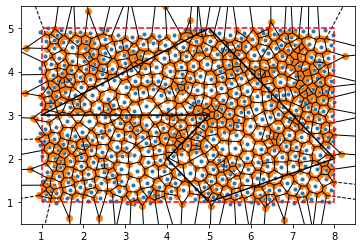

In [51]:
vor = Voronoi(points[:,:2])
voronoi_plot_2d(vor)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')
plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()

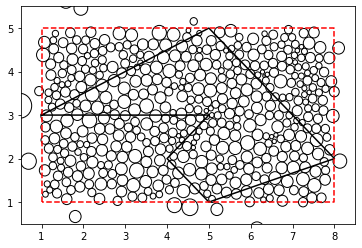

In [69]:
fig, ax = plt.subplots()

regions = []
vertices = vor.vertices
for i in vor.regions:
    if i and -1 not in i:
        regions.append(i)

# for i in regions:
#     poly = Polygon(np.array([vertices[j] for j in i]))
#     x,y = poly.exterior.xy
#     plt.plot(x,y,'b--')

particles = []

for i,region in enumerate(regions):
    #find define region and initalise grid of points over it
    reg_verts = []
    centroid = np.array([0.0,0.0])
    for i,v in enumerate(vertices):
        if i in region:
            reg_verts.append(v)
            centroid += v
    reg_verts = np.array(reg_verts)
    centroid /= len(reg_verts)
    #break out if centroi outside bounding box
    # if centroid[0] < xmin or centroid[0] > xmax or centroid[1] < ymin or centroid[1] > ymax:
    #     break
    xr,yr = max(reg_verts[:,0])-min(reg_verts[:,0]),max(reg_verts[:,1])-min(reg_verts[:,1])
    div = min(xr,yr)/30 # reduce this 25 for massive performace gains but worse accuracy
    #point grid
    x = np.arange(min(reg_verts[:,0])-div, max(reg_verts[:,0])+div, div)
    y = np.arange(min(reg_verts[:,1])-div, max(reg_verts[:,1]+div), div)
    nx,ny = len(x),len(y)
    grid = np.ones([nx,ny]) #ones mask
    #apply mask for each face
    poly = Polygon(np.array([vertices[i] for i in region]))
    for i in range(nx):
        for j in range(ny):
            if poly.contains(Point(x[i],y[j])) == False:
                grid[i,j] = 0
    samples = []
    for i in range(nx):
        for j in range(ny):
            if(grid[i,j] == 1):
                samples.append([x[i],y[j]])
    dt_image = ndimage.distance_transform_edt(grid)
    r = max(dt_image.flatten())
    cent_inscribed = np.where(dt_image == r)
    r = r*div

    cent_inscribed = list(zip(cent_inscribed[0],cent_inscribed[1]))[0]
    inscribed_circle = [x[cent_inscribed[0]], y[cent_inscribed[1]], r]
    particle = plt.Circle((inscribed_circle[0],inscribed_circle[1]), inscribed_circle[2], fill=False, color = 'black')
    ax.add_patch(particle)
    particles.append(inscribed_circle)

# for i in regions:
#     poly = Polygon(np.array([vertices[j] for j in i]))
#     x,y = poly.exterior.xy
#     plt.plot(x,y)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()

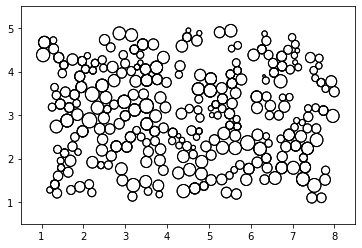

In [70]:
connectivity(particles)

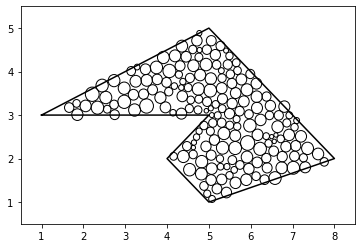

In [167]:
shell = Polygon(polygon)
particles = np.array([i for i in particles if shell.contains(Point(i[:2]))])

fig, ax = plt.subplots()
for i in particles:
    particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
    ax.add_patch(particle)

plt.plot(polygon[:,0],polygon[:,1],color = 'black')
# plt.plot([xmin,xmin,xmax,xmax,xmin],[ymin,ymax,ymax,ymin,ymin],'r--')

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()


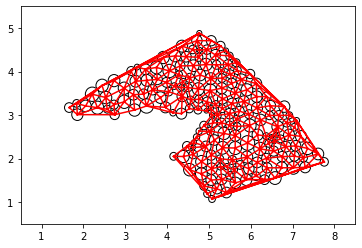

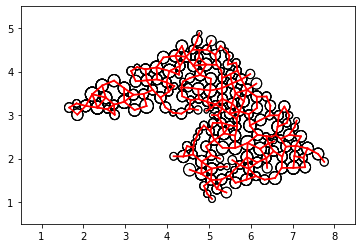

In [174]:
fig, ax = plt.subplots()
for i in particles:
    particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
    ax.add_patch(particle)

delan = Delaunay(np.array(particles)[:,:2])
# delaunay_plot_2d(delan)

simps = []
for i in delan.simplices:
    for j,v in enumerate(i):
        for k in i[j+1:]:
            if ((particles[v][0]-particles[k][0])**2 + (particles[v][1]-particles[k][1])**2)**0.5 < 0.2:
                simps.append([particles[v][:2],particles[k][:2]])


simps = [i for i in delan.simplices if shell.contains(Polygon([particles[i[0],:2],particles[i[1],:2],particles[i[2],:2]])) == True]
plt.triplot(particles[:,0], particles[:,1],simps,color = 'r')

# print(delan.vertices)

plt.xlim([xmin-0.5,xmax+0.5])
plt.ylim([ymin-0.5,ymax+0.5])
plt.show()
connectivity(particles)

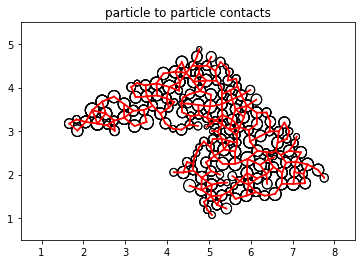

In [178]:
def connectivity(particles_):
    conect = []

    delan = Delaunay(np.array(particles_)[:,:2])

    simps_ = []
    for i in delan.simplices:
        for j,v in enumerate(i):
            for w in i[j+1:]:
                if ((particles_[v][0]-particles_[w][0])**2 + (particles_[v][1]-particles_[w][1])**2)**0.5 <= (particles_[v][2]+particles_[w][2])*1.1:
                    conect.append(particles_[v])
                    conect.append(particles_[w])
                    simps_.append([particles_[v][:2],particles_[w][:2]])

    # for i in simps_:
    #     print(i)

    fig, ax = plt.subplots()
    for i in conect:
        particle = plt.Circle((i[0],i[1]), i[2], fill=False, color = 'black')
        ax.add_patch(particle)

    for i in simps_:
        plt.plot([i[0][0],i[1][0]],[i[0][1],i[1][1]],'r')
    
    plt.xlim([xmin-0.5,xmax+0.5])
    plt.ylim([ymin-0.5,ymax+0.5])
    plt.title('particle to particle contacts')
    plt.savefig('p-p_contacts', dpi=300)
    plt.show()

connectivity(particles)